This project requires installation of Keras on Tensorflow as Backend
Installation instructions can be accessed at


https://medium.com/@margaretmz/anaconda-jupyter-notebook-tensorflow-and-keras-b91f381405f8

Ensure Keras is configued as per link.
For the purpose of demonstartion, this exercise has been executed on google colab(Free).

Estimated time for the code to produce forecasts on google colab is about 8hrs, which can be potentially be reduced to a few minutes if using a high end machine on AWS running a deep learning AMI.

In [1]:
#imports
import tensorflow as tf
#Lib for computations on Dataframe
import pandas as pd
import io
#Package to access boiler temeprature file from local google drive
from google.colab import files

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
#Keras package (wrapper on tf i.e keras on tensorflow as backend for math computations)

from keras.models import Sequential
# Stateful Dense ( atleast 3 layers network)
from keras.layers import Dense
# Long Short Term Memory Recurrent Neural Network Model
from keras.layers import LSTM
from math import sqrt
# Packages for visualization
from matplotlib import pyplot
from numpy import array
from datetime import datetime, timedelta

Using TensorFlow backend.


The data file has been uploaded to google drive and is acced by google's colab package

In [2]:
uploaded = files.upload()
#Main dataframe
df = pd.read_csv(io.StringIO(uploaded['boiler-flow-temperature.csv'].decode('utf-8')))

Saving boiler-flow-temperature.csv to boiler-flow-temperature.csv


Quick snapshot into the dataset

In [3]:
df.columns = ['eventId', 'deviceID', 'timestamp', 'value']
df.head()

,eventId,deviceID,timestamp,value
0,49808a3d-12b3-4534-ae55-df2cb8515756,23e67727-5e01-410a-adb2-5a347a8ec2f2,1543622414000,35.50
1,f66f34cc-a43d-4674-8ad3-2f151af5f06a,23e67727-5e01-410a-adb2-5a347a8ec2f2,1543622715000,35.25
2,80636d00-22c9-4903-8993-1f8b9be2ee8e,23e67727-5e01-410a-adb2-5a347a8ec2f2,1543623014000,35.00
3,d0971394-6a71-4481-8c7c-77d3aa222a6a,23e67727-5e01-410a-adb2-5a347a8ec2f2,1543623314000,34.75
4,a2199ebe-6fbd-4724-977d-9930ab04d2fe,23e67727-5e01-410a-adb2-5a347a8ec2f2,1543623614000,34.50


In [4]:
df.count()

eventId      8484
deviceID     8484
timestamp    8484
value        8484
dtype: int64

Exploratory Analysis revealed that the time series did not pertian to data captured in 1 month at every 5 minute intervals
Also the time series had captured data which were not at equal intervals

Manioualtion of the timestamp was necessary to simulate 5 minute data capture

In [5]:
df['timestamp'] = df['timestamp'].apply(lambda x: pd.Timestamp(x))

def get_datetime_range(start, end, delta):
    current = start
    while current < end:
        yield current
        current += delta
        
#Set dates 5 minute interval between Sep and Oct 2018
dt_list = [dt for dt in 
       get_datetime_range(datetime(2018, 9, 2, 0), datetime(2018, 10, 1, 9+12), 
       timedelta(minutes=5))]

dts = dt_list[0:8484]
#Manipulated Index of Dataset
df.index = dts
# For the demonstration purpose, we drop the following cols
df = df.drop(['timestamp', 'eventId', 'deviceID'], axis=1)
df.head()

,value
2018-09-02 00:00:00,35.50
2018-09-02 00:05:00,35.25
2018-09-02 00:10:00,35.00
2018-09-02 00:15:00,34.75
2018-09-02 00:20:00,34.50


Visualize the Data

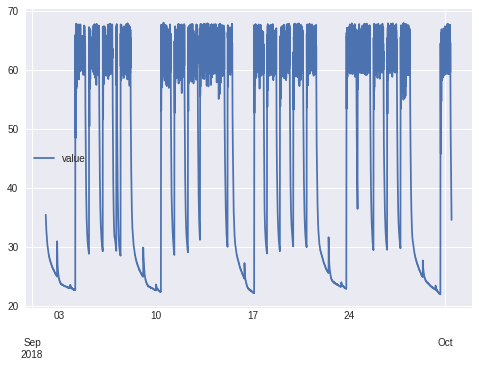

In [6]:
df.plot()
pyplot.show()

Some basic configurations for our LSTM

In [0]:
# Forecast 3 timesteps ahead
number_timesteps_out = 3
# configure the model
# lag of 1 timestep to be included in features
number_timestep_lag_feature = 1
number_of_obs_in_test = 2000
number_of_epochs = 1500
batch = 1
number_of_input_neurons = 1
dataset = df

Series Data with just one column of temepratures should now be transformed into Input - Target Dataframe

The current plan is to configure an LSTM to take in input at one timestep and predict data for 3 time steps ( 2 in the future and 1 in the past )

When any one of the forecasted values differ to the actual of RMSE of atleast 40% we can confidently say we have an anomaly to investigate


In [0]:
def series_to_supervised(data, timestep_in=1, timestep_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = pd.DataFrame(data)
	features, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(timestep_in, 0, -1):
		features.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, timestep_out):
		features.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	trans_df = pd.concat(features, axis=1)
	trans_df.columns = names
	# drop rows with NaN values
	if dropnan:
		trans_df.dropna(inplace=True)
	return trans_df

In [0]:
# transformormation of dataframe into train and test sets for supervised learning
# We will model the anomaly detection problem as a supervised learning problem

def setup_series(dataset, test, lag, out_len):
	raw_values = dataset.values
# Make time series data to be stationary
	diff_series = difference(raw_values, 1)
	diff_values = diff_series.values
	diff_values = diff_values.reshape(len(diff_values), 1)
	print(diff_values)
# Model Outlier Detection as a Supervised Learning Problem
# Normalize Data, using Min Max from scipy
	scaler = MinMaxScaler(feature_range=(-1, 1))
	scaled_values = scaler.fit_transform(diff_values)
	scaled_values = scaled_values.reshape(len(scaled_values), 1)
	supervised = series_to_supervised(scaled_values, lag, out_len)
	supervised_values = supervised.values

# split into training set and 1000 for testing set
	train, test = supervised_values[0:-test], supervised_values[-test:]
	print(supervised.head())
	return scaler, train, test

In [0]:
def difference(dataset, interval=1):
	diff = list()
	for i in range(interval, len(dataset)):
		value = dataset[i] - dataset[i - interval]
		diff.append(value)
	return pd.Series(diff)

In [11]:
# Setup and configure the dataset
scaler, train, test = setup_series(dataset, number_of_obs_in_test, number_timestep_lag_feature, number_timesteps_out)



[[array([-0.25])]
 [array([-0.25])]
 [array([-0.25])]
 ...
 [array([-0.4375])]
 [array([-0.8125])]
 [array([-0.375])]]
   var1(t-1)   var1(t)  var1(t+1)  var1(t+2)
1  -0.530303 -0.530303  -0.530303  -0.530303
2  -0.530303 -0.530303  -0.530303  -0.527778
3  -0.530303 -0.530303  -0.527778  -0.527778
4  -0.530303 -0.527778  -0.527778  -0.520202
5  -0.527778 -0.527778  -0.520202  -0.537879


/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:595: DataConversionWarning: Data with input dtype object was converted to float64 by MinMaxScaler.
  warnings.warn(msg, DataConversionWarning)


In [0]:
# fit an LSTM network to training data
def fit_lstm_model(train, lag, out_steps, batch, epochs, neurons_in):
	# resshape train dataset
	X, y = train[:, 0:lag], train[:, lag:]
	X = X.reshape(X.shape[0], 1, X.shape[1])
	# setup Network
	model = Sequential()
	model.add(LSTM(neurons_in, batch_input_shape=(batch, X.shape[1], X.shape[2]), stateful=True))
	model.add(Dense(y.shape[1]))
	model.compile(loss='mean_squared_error', optimizer='adam')
	# fit NN
	for i in range(epochs):
		print('Training at epoch :'+str(i))
		model.fit(X, y, epochs=1, batch_size=batch, verbose=0, shuffle=False)
		model.reset_states()
	print('Model training complete')
	return model

In [13]:
# experiment fitting LSTM model to datasets
model = fit_lstm_model(train, number_timestep_lag_feature, number_timesteps_out, batch, number_of_epochs, number_of_input_neurons)


Training at epoch :0
Training at epoch :1
Training at epoch :2
Training at epoch :3
Training at epoch :4
Training at epoch :5
Training at epoch :6
Training at epoch :7
Training at epoch :8
Training at epoch :9
Training at epoch :10
Training at epoch :11
Training at epoch :12
Training at epoch :13
Training at epoch :14
Training at epoch :15
Training at epoch :16
Training at epoch :17
Training at epoch :18
Training at epoch :19
Training at epoch :20
Training at epoch :21
Training at epoch :22
Training at epoch :23
Training at epoch :24
Training at epoch :25
Training at epoch :26
Training at epoch :27
Training at epoch :28
Training at epoch :29
Training at epoch :30
Training at epoch :31
Training at epoch :32
Training at epoch :33
Training at epoch :34
Training at epoch :35
Training at epoch :36
Training at epoch :37
Training at epoch :38
Training at epoch :39
Training at epoch :40
Training at epoch :41
Training at epoch :42
Training at epoch :43
Training at epoch :44
Training at epoch :4

In [0]:
def make_forecasts(model, batch, train, test, lag, out_steps):	
	forecasts = list()
	for i in range(len(test)):
		X, y = test[i, 0:lag], test[i, lag:]
		forecast = forecast_lstm(model, X, batch)
		forecasts.append(forecast)
	return forecasts

In [0]:
def forecast_lstm(model, X, n_batch):
# reshape input pattern to [obs, timesteps, features]
		X = X.reshape(1, 1, len(X))
		forecast = model.predict(X, batch_size=n_batch)
# convert to array
		return [x for x in forecast[0, :]]

In [0]:
# make forecasts
forecasts = make_forecasts(model, batch, train, test, number_timestep_lag_feature, number_timesteps_out)


In [17]:
print(forecasts)

[[-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.6260195, -0.4177633, -0.59800726], [-0.46089607, -0.5703701, -0.47684252], [-0.6262518, -0.4175486, -0.59817773], [-0.46089607, -0.5703701, -0.47684252], [-0.6262622, -0.417539, -0.59818536], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0.46089607, -0.5703701, -0.47684252], [-0

In [0]:
# invert differenced forecast
def inverse_difference(ob, forecast):
	inverted = list()
	inverted.append(forecast[0] + ob)
	for i in range(1, len(forecast)):
		inverted.append(forecast[i] + inverted[i-1])
	return inverted

# inverse data transform on forecasts
def inverse_transform(series, forecasts, scaler, test):
	inverted = list()
	for i in range(len(forecasts)):
		forecast = array(forecasts[i])
		forecast = forecast.reshape(1, len(forecast))
		# invert normalization
		inv_scale = scaler.inverse_transform(forecast)
		inv_scale = inv_scale[0, :]
		# invert differencing
		index = len(series) - test + i - 1
		last_ob = series.values[index]
		inv_diff = inverse_difference(last_ob, inv_scale)
		# store
		inverted.append(inv_diff)
	return inverted

In [0]:
# inverse transform forecasts and test
forecasts = inverse_transform(dataset, forecasts, scaler, number_of_obs_in_test+2)


In [20]:
print(forecasts)

[[array([63.65532219]), array([62.41366279]), array([63.48681045])], [array([62.78032219]), array([61.53866279]), array([62.61181045])], [array([65.15532219]), array([63.91366279]), array([64.98681045])], [array([61.15532219]), array([59.91366279]), array([60.98681045])], [array([62.19351792]), array([64.72887635]), array([62.80319655])], [array([61.40532219]), array([60.16366279]), array([61.23681045])], [array([62.87526751]), array([65.41593957]), array([63.48604071])], [array([62.34282219]), array([61.10116279]), array([62.17431045])], [array([64.31251073]), array([66.8534205]), array([64.92333281])], [array([63.59282219]), array([62.35116279]), array([63.42431045])], [array([61.65532219]), array([60.41366279]), array([61.48681045])], [array([65.21782219]), array([63.97616279]), array([65.04931045])], [array([61.09282219]), array([59.85116279]), array([60.92431045])], [array([58.90532219]), array([57.66366279]), array([58.73681045])], [array([57.28032219]), array([56.03866279]), arr

In [21]:
from matplotlib.pyplot import figure
figure(num=None, figsize=(20, 18), dpi=80, facecolor='w', edgecolor='k')

# evaluate the RMSE for each forecast time step
def evaluate_forecasts(test, forecasts, lag, out_steps):
	for i in range(out_steps):
		actual = [row[i] for row in test]
		predicted = [forecast[i] for forecast in forecasts]
		rmse = sqrt(mean_squared_error(actual, predicted))
		print('t+%d RMSE: %f' % ((i+1), rmse))

# plot the forecasts in the context of the original dataset
def plot_forecasts(series, forecasts, n_test):
	# plot the entire dataset in blue
	pyplot.plot(series.values)
	# plot the forecasts in red
	for i in range(len(forecasts)):
		off_s = len(series) - n_test + i - 1
		off_e = off_s + len(forecasts[i]) + 1
		xaxis = [x for x in range(off_s, off_e)]
		yaxis = [series.values[off_s]] + forecasts[i]
		pyplot.plot(xaxis, yaxis, color='red')
	# show the plot
	pyplot.show()

<Figure size 1600x1440 with 0 Axes>

In [0]:
actual = [row[number_timestep_lag_feature:] for row in test]
actual = inverse_transform(dataset, actual, scaler, number_of_obs_in_test+2)

In [23]:
# evaluate forecasts
evaluate_forecasts(actual, forecasts, number_timestep_lag_feature, number_timesteps_out)


t+1 RMSE: 3.403579
t+2 RMSE: 3.109736
t+3 RMSE: 4.128305


Visualize the forecast for the next 2000 data points in RED

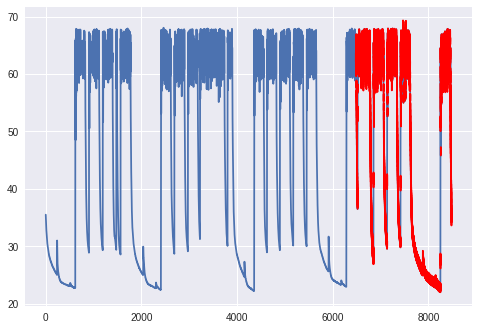

In [24]:
# plot forecasts
plot_forecasts(dataset, forecasts, number_of_obs_in_test+2)

Conclusion

Given that the objective is to idetify whether the current temperature sensor read is an anomaly or not, a calculation of the rmse on the predicted will be the first step.

If a certain amount of threshold is set for allowance, the the rmse can be a fairly good indicator of a possible anomaly.

Note: The neural network had an rmse of 3 for an unseen data of 2000 points in comparison with training data of 6484 data points.

However on increasing the training data to 8474 data points and test/unseen data to 10 data points then the RMSE shot down to 1.2.. which is an excellent prediction of the
next 10 steps.

Code for anomaly check:
rmse = sqrt(mean_squared_error(actual, predicted))